# Analysis of the Cicero corpus & comparison to other authors and works

In [1]:
import os.path
from collections import Counter
from glob import glob
import inspect
import os
import pickle
import sys
from typing import List, Dict, Tuple

from cltk.corpus.latin.phi5_index import PHI5_INDEX
from cltk.corpus.readers import get_corpus_reader
from cltk.stem.latin.j_v import JVReplacer
from cltk.stem.lemma import LemmaReplacer
from cltk.tokenize.latin.sentence import SentenceTokenizer
from cltk.tokenize.word import WordTokenizer
from random import sample
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
plt.style.use('fivethirtyeight')


currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
 
from mlyoucanuse.aeoe_replacer import AEOEReplacer
from mlyoucanuse.text_cleaners import ( normalize_accents, disappear_angle_brackets,
                                        drop_punct, disappear_round_brackets,
                                        truecase, dehyphenate, accept_editorial,
                                        swallow_braces, swallow_obelized_words,
                                        swallow_square_brackets)

AttributeError: module 'typing' has no attribute 'OrderedDict'

In [74]:
from scipy.optimize import curve_fit
import numpy as np

In [2]:
import cltk
cltk.__version__

'0.1.121'

## Text Cleaning
from http://udallasclassics.org/wp-content/uploads/maurer_files/APPARATUSABBREVIATIONS.pdf

[...] Square brackets, or in recent editions wavy brackets ʺ{...}ʺ, enclose words etc. that an editor thinks should be deleted (see ʺdel.ʺ) or marked as out of place (see ʺsecl.ʺ).

[...] Square  brackets  in  a  papyrus  text, or in an  inscription,  enclose  places  where words have been lost through physical damage.  If this happens in mid-line, editors  use  ʺ[...]ʺ.    If  only  the  end  of  the  line  is  missing,  they  use  a  single  bracket ʺ[...ʺ      If  the  lineʹs  beginning  is  missing,  they  use  ʺ...]ʺ    Within  the  brackets, often each dot represents one missing letter.

[[...]] Double brackets enclose letters or words deleted by the medieval copyist himself.

(...) Round  brackets  are  used  to  supplement  words  abbreviated  by  the  original  copyist; e.g. in an inscription: ʺtrib(unus) mil(itum) leg(ionis) IIIʺ

<...> diamond  (  =  elbow  =  angular)  brackets  enclose  words  etc.  that  an  editor  has  added (see ʺsuppl.ʺ)

†   An obelus (pl. obeli) means that the word(s etc.) is very plainly corrupt, but the editor  cannot  see  how  to  emend.    If  only  one  word  is  corrupt,  there  is  only  one obelus, which precedes the word; if two or more words are corrupt, two obeli  enclose  them.    (Such  at  least  is  the  rule--but  that  rule  is  often  broken,  especially  in  older  editions,  which  sometimes  dagger  several  words  using  only one obelus.)  To dagger words in this way is to ʺobelizeʺ them.

## Load/Build Truecasing dictionary; count all cased tokens, use to normalize cases later

In [3]:
truecase_file = 'truecase_counter.latin.final.pkl'

if os.path.exists(truecase_file):
    with open(truecase_file, 'rb') as fin:        
        case_counts = pickle.load(fin)
else:
    tesserae = get_corpus_reader(corpus_name='latin_text_tesserae', language='latin')
    case_counts = Counter()
    jv_replacer = JVReplacer()
    aeoe_replacer = AEOEReplacer()
    toker = WordTokenizer('latin')
    sent_toker = SentenceTokenizer()
    lemmatizer = LemmaReplacer('latin')
    
    for file in tqdm(tesserae.fileids(), total=len(tesserae.fileids())):
        for sent in tesserae.sents(file):
            sent = aeoe_replacer.replace(jv_replacer.replace(drop_punct(sent)))
            sent = normalize_accents(sent)
            sent = accept_editorial(sent)
            for idx, token in enumerate(toker.tokenize(sent)):
                if idx ==0: # skip the first word, it almost always capitalized
                    continue
                case_counts.update({token:1})
                
    with open(truecase_file, 'wb') as fout:        
        pickle.dump(case_counts, fout) 

len(case_counts)
# 344393, 322711  
# 318451
# 316722
# 311399
# 310384
# 310567
# 309529

309529

In [4]:
print(sample(list(case_counts.items()), 25))

[('ligula', 1), ('inponerent', 4), ('oblidere', 1), ('stridebit', 2), ('Hectorem', 12), ('obtemperabat', 4), ('Gabathites', 1), ('terreant', 5), ('corrupimus', 1), ('uigentes', 7), ('saepedicto', 1), ('coniugio', 61), ('μονοτονία', 1), ('skai', 1), ('sationibus', 5), ('Suffusus', 1), ('ἔγγιον', 1), ('οὐρανὸς', 3), ('adhereret', 1), ('supercrepitante', 1), ('coli', 92), ('adolet', 3), ('discessisset', 20), ('Comploratum', 1), ('Decumo', 1)]


In [5]:
def get_word_counts(files:List[str])->Tuple[Dict[str, int], Dict[str, int]]:
    """
    Given a list of files, 
    clean & tokenize the documents
    returns: Tuple(counter of lemmatized words, counter of inflected words)
    """
    lemma_word_counter = Counter()
    inflected_word_counter = Counter()
    jv_replacer = JVReplacer()
    aeoe_replacer = AEOEReplacer()
    toker = WordTokenizer('latin')
    sent_toker = SentenceTokenizer()
    lemmatizer = LemmaReplacer('latin')

    for file in files: # , total=len(files), unit='files'):
        with open(file, 'rt') as fin:
            text = fin.read()
            text = text.replace("-\n", "")
            text = text.replace("\n", " ")
            text = aeoe_replacer.replace(jv_replacer.replace( text))
            for sent in sent_toker.tokenize(text):
                sent = dehyphenate(sent) # because it's Phi5
                sent = swallow_braces(sent)
                sent = swallow_square_brackets(sent)
                sent = disappear_round_brackets(sent)
                sent = swallow_obelized_words(sent)
                sent = disappear_angle_brackets(sent)            
                sent = drop_punct(sent)
                sent = normalize_accents(sent)            
                # lemmatizer prefers lower 
    #             sent = lemmatizer.lemmatize(sent.lower(), return_string=True)
                for word in toker.tokenize(sent):
                    if word.isnumeric():
                        continue
                    inflected_word_counter.update({truecase(word, case_counts) : 1})                    
                    word = lemmatizer.lemmatize(word.lower(), return_string=True)
                    # normalize capitals
                    lemma_word_counter.update({truecase(word, case_counts) : 1})
    return  inflected_word_counter, lemma_word_counter

In [6]:
def word_stats(author:str,
               inflected_counter:Counter,
                lemma_counter:Counter)->Tuple[float, float]:
    """
    Compute statistics for an author's corpus
    """
    nw = sum(lemma_counter.values())
    print(f"Total count of all word tokens in {author} corpus: {nw:,}")
    print(f"Total number of distinct, inflected words/tokens in {author} corpus: {len(inflected_counter):,}")
    print(f"Total number of lemmatized words/tokens in {author} corpus {len(lemma_counter):,}")
    # Count of inflected unigrams occuring only once
    ciw1 = sum([1 for key, val in inflected_counter.items() if val == 1]) 
    print(f"Count of inflected tokens only occuring once {ciw1:,}")
    # Count of lemmatized unigrams occuring only once
    cw1 = sum([1 for key, val in lemma_counter.items() if val == 1])
    print(f"Count of lemmatized tokens only occuring once {cw1:,}")
    Piu_one = round(ciw1 / nw,3)
    print(f"Probability of a single count unigram occuring in the {author} corpus: {Piu_one:.3f}") 
    Plu_one = round(cw1 / nw, 3)
    print(f"Probability of a single count lemmatized unigram in a novel form occuring in the {author} corpus: {Plu_one:.3f}") 
    return (Piu_one, Plu_one)

In [7]:
# Cicero works
cicero_files = glob(f"{os.path.expanduser('~')}/cltk_data/latin/text/phi5/individual_works/LAT0474.TXT-0*.txt")
len (cicero_files)              

75

In [8]:
cicero_lemmas_counter_file = 'cicero_lemmas_counter.pkl'
cicero_inflected_counter_file = 'cicero_inflected_counter.pkl'

if os.path.exists(cicero_lemmas_counter_file) and os.path.exists(cicero_inflected_counter_file):
    with open(cicero_lemmas_counter_file, 'rb') as fin:
        cicero_lemmas = pickle.load(fin)
    with open(cicero_inflected_counter_file, 'rb') as fin:
        cicero_inflected_words = pickle.load(fin)
else:
    cicero_inflected_words, cicero_lemmas  = get_word_counts(cicero_files)

In [9]:
if not os.path.exists(cicero_lemmas_counter_file):
    with open(cicero_lemmas_counter_file, 'wb') as fout:
        pickle.dump(cicero_lemmas, fout)
if not os.path.exists(cicero_inflected_counter_file):
    with open(cicero_inflected_counter_file, 'wb') as fout:
        pickle.dump(cicero_inflected_words, fout)

In [10]:
word_stats(author='Cicero',           
            inflected_counter=cicero_inflected_words,
            lemma_counter=cicero_lemmas)

Total count of all word tokens in Cicero corpus: 1,196,512
Total number of distinct, inflected words/tokens in Cicero corpus: 75,705
Total number of lemmatized words/tokens in Cicero corpus 23,345
Count of inflected tokens only occuring once 34,608
Count of lemmatized tokens only occuring once 10,656
Probability of a single count unigram occuring in the Cicero corpus: 0.029
Probability of a single count lemmatized unigram in a novel form occuring in the Cicero corpus: 0.009


(0.029, 0.009)

In [15]:
word_counts =  sorted(cicero_inflected_words.items(), key=lambda x:x[1], reverse=True)
# words, counts = zip(*word_counts)


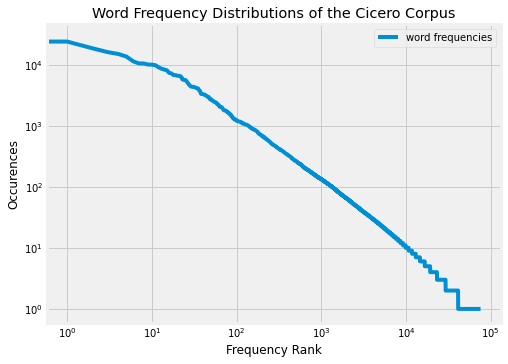

In [180]:
top_label, side_label, bottom_label = ('Frequency Rank',
                                       'Occurences',
                                       'Word Frequency Distributions of the Cicero Corpus')
fig = plt.figure(figsize=(7,5))
plt.xlabel(top_label)
plt.ylabel(side_label)
plt.title(bottom_label)
ax = fig.gca()
plt.yscale('log')
indices, values = zip(*word_counts)
# plt.bar(range(len(values)), values)
plt.loglog(range(len(values)), values, label='word frequencies')
# plt.axvline(x=np.mean(all_vals), color='k', linestyle='-', label='mean')
# plt.axvline(x=np.mean(all_vals) + np.std(all_vals), color='b', linestyle='-', label='std')
# plt.axvline(x=np.mean(all_vals) + (2 * np.std(all_vals)), color='m', linestyle='-', label='std2')
plt.legend(loc='upper right')
plt.tight_layout(pad=0.5, w_pad=20, h_pad=0.5)
# plt.show()
plt.savefig('cicero_frequency_distributions.png')

In [18]:
word_counts[:5]

[('et', 27952), ('in', 23862), ('non', 18471), ('est', 16045), ('ut', 14957)]

In [20]:
word_counts[-5:]

[('adaequatus', 1),
 ('obfuerint', 1),
 ('ignorauit', 1),
 ('erudiri', 1),
 ('adprobarunt', 1)]

In [25]:
first_last = word_counts[:5] +word_counts[-5:]

No handles with labels found to put in legend.


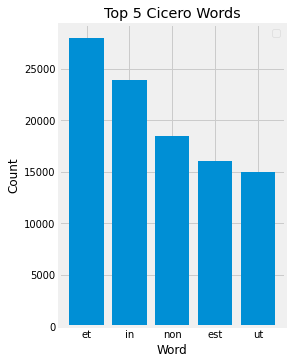

In [181]:
top_label, side_label, bottom_label = ('Word',
                                       'Count',
                                       'Top 5 Cicero Words')
fig = plt.figure(figsize=(4,5))
plt.xlabel(top_label)
plt.ylabel(side_label)
plt.title(bottom_label)
ax = fig.gca()
# plt.yscale('log')
# word_counts[:5] +word_counts[-5:]
indices, values = zip(*word_counts[:5])
plt.bar(indices , values)
# plt.loglog(range(len(values)), values, label='word frequencies')
# plt.axvline(x=np.mean(all_vals), color='k', linestyle='-', label='mean')
# plt.axvline(x=np.mean(all_vals) + np.std(all_vals), color='b', linestyle='-', label='std')
# plt.axvline(x=np.mean(all_vals) + (2 * np.std(all_vals)), color='m', linestyle='-', label='std2')
plt.legend(loc='upper right')
plt.tight_layout(pad=0.5, w_pad=20, h_pad=0.5)
# plt.show()
plt.savefig('cicero_top5_words.png')

In [192]:
num_f1 = sum([1 for tmp, cnt in cicero_inflected_words.items() if cnt == 1])
num_f2 = sum([1 for tmp, cnt in cicero_inflected_words.items() if cnt == 2])
num_f3 = sum([1 for tmp, cnt in cicero_inflected_words.items() if cnt == 3])
num_f4 = sum([1 for tmp, cnt in cicero_inflected_words.items() if cnt == 4])
num_f5 = sum([1 for tmp, cnt in cicero_inflected_words.items() if cnt == 5])
values=[num_f5, num_f4, num_f3, num_f2, num_f1 ]

In [193]:
values

[2622, 3936, 6095, 11858, 34608]

In [195]:
p0 = round(34608 / sum(cicero_inflected_words.values()),3)
p0

0.029

In [196]:
sum(cicero_inflected_words.values())

1196512

In [204]:
for i in range(1,20):
    print(i, sum([1 for tmp, cnt in cicero_inflected_words.items() if cnt == i]))

1 34608
2 11858
3 6095
4 3936
5 2622
6 2018
7 1572
8 1260
9 1018
10 837
11 705
12 600
13 525
14 467
15 433
16 367
17 319
18 316
19 275


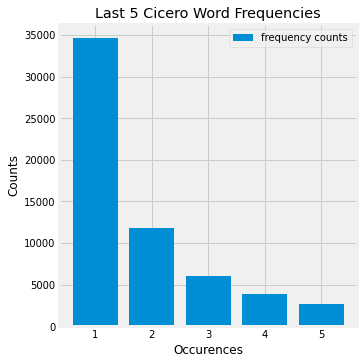

In [182]:
top_label, side_label, bottom_label = ('Occurences',
                                       'Counts',
                                       'Last 5 Cicero Word Frequencies')
fig = plt.figure(figsize=(5,5))
plt.xlabel(top_label)
plt.ylabel(side_label)
plt.title(bottom_label)
ax = fig.gca()
plt.yscale('linear')
# indices, values = zip(*word_counts[-5:])
values = [num_f1, num_f2, num_f3, num_f4, num_f5]
plt.bar(range(1,len(values)+1), values, label='frequency counts')
# plt.loglog(range(len(values)), values, label='word frequencies')
# plt.axvline(x=np.mean(all_vals), color='k', linestyle='-', label='mean')
# plt.axvline(x=np.mean(all_vals) + np.std(all_vals), color='b', linestyle='-', label='std')
# plt.axvline(x=np.mean(all_vals) + (2 * np.std(all_vals)), color='m', linestyle='-', label='std2')
plt.legend(loc='upper right')
plt.tight_layout(pad=0.5, w_pad=20, h_pad=0.5)
# plt.show()
plt.savefig('cicero_last_five_word_frequencies.png')

In [116]:
# Calc lemmatized

In [ ]:
# Probability of a single count unigram occuring in the Cicero corpus: 0.029
# Probability of a single count lemmatized unigram in a novel form occuring in the Cicero corpus: 0.009
# (0.029, 0.009)
# With Curve fitting
# Probability of encountering a new inflected word in new Cicero 0.054 (according to curve fitting)
# Probability of encountering a new lemmatized word form in new Cicero 0.017 (according to curve fitting)
# (0.054, 0.017)

Expected unknown count 32,361
Probability of encountering a new lemmatized word form in new Cicero 0.027 (according to curve fitting)
[(10, 249), (9, 280), (8, 332), (7, 406), (6, 542), (5, 644), (4, 959), (3, 1508), (2, 3108), (1, 10656)]


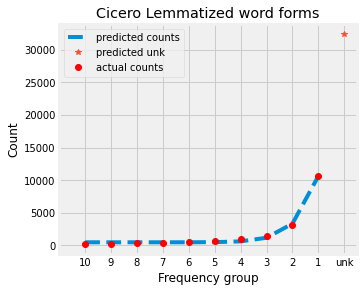

In [209]:
freq_vals = []
num_samples =10
for i in range(num_samples,0,-1):
    freq_vals.append( (i, sum([1 for tmp, cnt in cicero_lemmas.items() if cnt == i])))

X,y = zip(*freq_vals)
# We will reverse the scale to predict the next number according to a Power Law distribution
X =list(reversed(X))

def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c
  
popt, pcov = curve_fit(func_powerlaw, X, y, maxfev=2000)
expected_unk_count  = round(func_powerlaw(num_samples + 1 , *popt)) 
plt.figure(figsize=(5,4))
plt.plot(X, func_powerlaw(X, *popt), '--', label='predicted counts')
plt.plot(X[-1] + 1, func_powerlaw(X[-1]+1, *popt), '*', label='predicted unk')
plt.plot(X, y, 'ro', label='actual counts')
plt.title("Cicero Lemmatized word forms")
plt.xlabel("Frequency group" )
plt.ylabel("Count")
locs, labels = plt.xticks()  
plt.xticks(range(12), ['']+ [str(tmp) for tmp in range(10,0,-1)] +['unk']) 
plt.legend()
# plt.show()
plt.tight_layout(pad=0.5, w_pad=20, h_pad=0.5)
plt.savefig('cicero_lemmatized_words_unk_prob_curve_fit.png')

expected_unk_count  = round(func_powerlaw(num_samples + 1, *popt) ) 
P_new_lemma_word = expected_unk_count / sum(cicero_lemmas.values())
print(f"Expected unknown count {expected_unk_count:,}")
print(f"Probability of encountering a new lemmatized word form in new Cicero {round(P_new_lemma_word,3)} (according to curve fitting)")
print(freq_vals)

Expected unknown count 88,198
Probability of encountering a new word in new Cicero 0.074 (according to curve fitting)
[(10, 837), (9, 1018), (8, 1260), (7, 1572), (6, 2018), (5, 2622), (4, 3936), (3, 6095), (2, 11858), (1, 34608)]


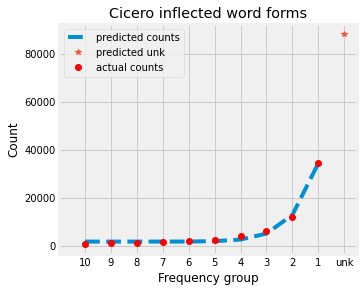

In [210]:
freq_vals = []
num_samples = 10
for i in range(num_samples,0,-1):
    freq_vals.append( (i, sum([1 for tmp, cnt in cicero_inflected_words.items() if cnt == i])))

X,y = zip(*freq_vals)
# We will reverse the scale to predict the next number according to a Power Law distribution
X =list(reversed(X))

def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c
 
popt, pcov = curve_fit(func_powerlaw, X, y, maxfev=2000)
expected_unk_count  = round(func_powerlaw(num_samples + 1 , *popt)) 
plt.figure(figsize=(5,4))
plt.plot(X, func_powerlaw(X, *popt), '--', label='predicted counts')
plt.plot(X[-1] + 1, func_powerlaw(X[-1]+1, *popt), '*', label='predicted unk')
plt.plot(X, y, 'ro', label='actual counts')
plt.title("Cicero inflected word forms")
plt.xlabel("Frequency group" )
plt.ylabel("Count")
locs, labels = plt.xticks()  
plt.xticks(range(12), ['']+ [str(tmp) for tmp in range(10,0,-1)] +['unk']) 
plt.legend()
# plt.show()
plt.tight_layout(pad=0.5, w_pad=20, h_pad=0.5)
plt.savefig('cicero_inflected_words_unk_prob_curve_fit.png')

expected_unk_count  = round(func_powerlaw(num_samples + 1 , *popt)) 
P_new_word = expected_unk_count / sum(cicero_inflected_words.values())
print(f"Expected unknown count {expected_unk_count:,}")
print(f"Probability of encountering a new word in new Cicero {round(P_new_word,3)} (according to curve fitting)")
print(freq_vals)

In [149]:
# Probability of a single count unigram occuring in the Cicero corpus: 0.029
# Probability of a single count lemmatized unigram in a novel form occuring in the Cicero corpus: 0.009
# (0.029, 0.009)
# With Curve fitting
# Probability of encountering a new inflected word in new Cicero 0.054 (according to curve fitting)
# Probability of encountering a new lemmatized word form in new Cicero 0.017 (according to curve fitting)
# (0.054, 0.017)
# With Power Law Curve fitting
# (0.074, 0.027)
# Probability of encountering a new inflected word in a new page of Cicero: 0.074
# Probability of encountering a new form of lemma in Cicero's use: 0.027

#  So, if you found a new page of Cicero with a 100 words
# we would expect 7 of the words to be new/hitherto/unseen in the Cicero corpus
# we would expect 3 of the words to be words that Cicero had used before, but now in novel forms of the lemmas 

### Good-Turing Frequency Estimation
\begin{align}
p_{0}={\frac {N_{1}}{N}}
\end{align}
The probability of an unseen element is equivalent to the the probability of elements seen only once.

In [211]:
88198/  1196512

0.07371259126527774

In [212]:
malum_potest = -127.67892735847873
potest_malum = -127.61667828754315

In [213]:
malum_potest - potest_malum

-0.06224907093557874

In [214]:
potest_malum - malum_potest

0.06224907093557874

In [11]:
author_index = {val:key for key,val in PHI5_INDEX.items()  
                if val != 'Marcus Tullius Cicero, Cicero, Tully'}

In [12]:
def get_phi5_author_files(author_name, author_index):
    stub = author_index[author_name]
    return glob(os.path.expanduser(f'~/cltk_data/latin/text/phi5/individual_works/{stub}*.txt'))

## Visualization of our corpus comparison: 
If you took one page from one author and placed it into Cicero, how surprising would it be?

If the other author's vocabulary was substantially different, it would be noticeable. We can quantify this.

As a result, since we want to predict as close as possible to the author, we should only train a language model where the underlying corpus vocabularies are within a reasonable window of surprise.

In [17]:
results = []
# The following code assumes this is in memory:
# cicero_lemmas, cicero_inflected_words = get_word_counts(cicero_files)    

for author in author_index:
    files = get_phi5_author_files(author, author_index)
    # Get a counter of all the author's distinct words & counter of words collapsed by lemmas
    author_inflected_words, author_lemmas  = get_word_counts(files)        
    # Calculate the overlap & find the differences; lemmas:
    author_words = set(author_lemmas.keys())
    cicero_words = set(cicero_lemmas.keys())
    common = author_words & cicero_words
    author_uniq = author_words - common 
    P_lemma_unigram_unk = len(author_uniq) / sum(author_lemmas.values())
    # now inflected forms: 
    author_words = set(author_inflected_words.keys())
    cicero_words = set(cicero_inflected_words.keys())
    common = author_words & cicero_words
    author_uniq = author_words - common 
    P_inflected_unigram_unk = len(author_uniq) / sum(author_inflected_words.values())
    results.append((author, round(P_inflected_unigram_unk, 3), round(P_lemma_unigram_unk, 3)))

100%|██████████| 1/1 [00:00<00:00, 533.56files/s]


100%|██████████| 1/1 [00:00<00:00,  4.98files/s]


In [18]:
results_map = {key: (val, val2) for key,val,val2 in results}

In [24]:
results = sorted(results, key=lambda x:x[2])

In [25]:
for tmp in results:
    print(tmp)

('Publius Cominius', 0.0, 0.0)
('Publius Cornelius Dolabella', 0.0, 0.0)
('Gaius Calpurnius Piso', 0.0, 0.0)
('Publius Saturius', 0.0, 0.0)
('Lucius Cassius Longinus', 0.0, 0.0)
('Gaius Memmius', 0.0, 0.0)
('Passienus Crispus', 0.0, 0.0)
('Marcus Antonius', 0.0, 0.0)
('Caecilius Metellus', 0.0, 0.0)
('Gaius Aurelius Cotta', 0.0, 0.0)
('Gaius Scribonius Curio avus', 0.0, 0.0)
('Vibius Crispus', 0.0, 0.0)
('Gallus Antipater', 0.0, 0.0)
('Lucius Herennius Balbus', 0.0, 0.0)
('Marcus Antonius triumvir', 0.0, 0.0)
('Sevius Nicanor', 0.0, 0.0)
('Gaius Papirius Carbo Arvina', 0.0, 0.0)
('Gaius vel Lucius Caepasius', 0.0, 0.0)
('Titus Labienus', 0.0, 0.0)
('Lucius Quinctius', 0.0, 0.0)
('Q. Lutatius Catulus iunior', 0.0, 0.0)
('Gaius Servilius Glaucia', 0.0, 0.0)
('Gaius Aquilius Gallus', 0.0, 0.0)
('Lucius Marcius Philippus', 0.0, 0.0)
('Iulius Africanus', 0.0, 0.0)
('Marcus Porcius Cato Uticensis', 0.0, 0.0)
('Publius Clodius Pulcher', 0.0, 0.0)
('Vagellius', 0.0, 0.0)
('Publius Mucius Scaev

In [29]:
author_results = []
for author in author_index:
    files = get_phi5_author_files(author, author_index)
    if len(files) >= 3:
#     print(author, results_map[author])
        author_results.append((author, results_map[author]) )

author_results.sort(key=lambda x: x[1][1])    
for tmp in author_results:
    print(tmp)
    
# the values analogous to Cicero are: (0.02892407263780054, 0.008905886443261747)    
# ~ 0.03  and  0.01 # we can tolerate some distance above this baseline, 2x, 3x, depends
# Results are mapped into Cicero's Vocabulary space
# Table below:
# Author
# Probability of encountering a word once that we've seen in the author previously in a different lemmatized form
# Probability of seeing a truly new word once in this authors corpus 

('Quintus Asconius Pedianus', (0.01, 0.03))
('Gaius, iur., Gaius', (0.011, 0.035))
('Titus Livius, Livy', (0.011, 0.039))
('Marcus Fabius Quintilianus', (0.009, 0.042))
('Gaius Iulius Caesar, Caesar', (0.016, 0.046))
('Lucius Annaeus Seneca senior', (0.016, 0.052))
('Lucius Annaeus Seneca iunior', (0.013, 0.054))
('Aulus Cornelius Celsus', (0.017, 0.056))
('Publius Terentius Afer, Terence', (0.029, 0.059))
('Gaius Sallustius Crispus', (0.021, 0.059))
('Maurus Servius Honoratus, Servius', (0.025, 0.059))
('Titus Maccius Plautus', (0.027, 0.062))
('Publius Ovidius Naso', (0.024, 0.065))
('C. Plinius Caecilius Secundus, Pliny', (0.017, 0.066))
('Titus Lucretius Carus', (0.022, 0.068))
('Scriptores Historiae Augustae', (0.032, 0.071))
('Cornelius Tacitus', (0.025, 0.076))
('Gaius Caesius Bassus', (0.04, 0.08))
('Hyginus Gromaticus', (0.029, 0.083))
('Marcus Valerius Probus', (0.038, 0.084))
('Marcus Cornelius Fronto', (0.036, 0.084))
('Gaius Asinius Pollio', (0.036, 0.09))
('Annius Florus'

#### Translating the statistics:
* Cicero: # ~ 0.03  and  0.01  
* Gaius Iulius Caesar, Caesar (0.016170899832329378, 0.0464137117307334)

#### If one were to find a new page (100 words) of Cicero, one would expect to find: 
* 3 words that Cicero had previously used, but in novel inflected forms 
    * (root words that we know have been used by Cicero, but without previous examples of that particular inflection)
* 1 word hapax legomena to the author
    * Not a global hapax legomena, but one that we have no record of occuring in Cicero before (in any inflected form).
#### if one were to take a page from Caesar and claim it was a new page of Cicero, one would expect to find:
* 2 words that Cicero had previously used but now in a novel inflected form.
* 5 words that Cicero had never used (in any inflected form).


In [18]:
# Let's look at Cicero's near contemporaries, and see if the individual works come closer to 
# matching Cicero's language in terms of Probability Distributions
candidates = ['Gaius Iulius Caesar, Caesar', 
'C. Iul. Caes. Augustus Octavianus',  
'Publius Vergilius Maro, Virgil, Vergil',  
'Gaius Suetonius Tranquillus', 
'Marcus Terentius Varro, Varro', 
'Cornelius Tacitus', 
'Titus Livius, Livy', 
'Lucius Annaeus Seneca senior', 
'Quintus Horatius Flaccus, Horace',  
'Gaius Sallustius Crispus', 
'Titus Lucretius Carus', 
'Lucius Annaeus Seneca iunior']

In [25]:
results = []

for author in candidates:
    files = get_phi5_author_files(author, author_index)
    #     cicero_lemmas, cicero_inflected_words = get_word_counts(cicero_files)    
    for file in files:
        author_inflected_words, author_lemmas = get_word_counts([file])    
        author_words = set(author_lemmas.keys())
        cicero_words = set(cicero_lemmas.keys())
        common = author_words & cicero_words
        author_uniq  = author_words - common 
        P_one_x_lemma_unigram = round(len(author_uniq) / sum(author_lemmas.values()),3)
        author_words = set(author_inflected_words.keys())
        cicero_words = set(cicero_inflected_words.keys())
        common = author_words & cicero_words
        author_uniq  = author_words - common 
        P_one_x_inflected_unigram = round(len(author_uniq) / sum(author_inflected_words.values()), 3)
        results.append((author, file, sum(author_inflected_words.values()), P_one_x_inflected_unigram, P_one_x_lemma_unigram))

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

  0%|          | 0/1 [00:00<?, ?files/s]

In [30]:
for author, _, count, P_one_x_inflected_unigram, P_one_x_lemma_unigram in results:
    if P_one_x_lemma_unigram != 0.0:
        print (author, count, P_one_x_inflected_unigram, P_one_x_lemma_unigram)
# Cicero's values for:
# Probability of unigrams that occur once, Probability of a lemmatized unigram occurring once
# (0.02892407263780054, 0.008905886443261747)  Cicero's values for

Gaius Iulius Caesar, Caesar 286 0.0034965034965034965 0.006993006993006993
Gaius Iulius Caesar, Caesar 134 0.08955223880597014 0.13432835820895522
Gaius Iulius Caesar, Caesar 386 0.0025906735751295338 0.0025906735751295338
Gaius Iulius Caesar, Caesar 49 0.061224489795918366 0.20408163265306123
Gaius Iulius Caesar, Caesar 33437 0.014923587642432037 0.0506923468014475
Gaius Iulius Caesar, Caesar 179 0.027932960893854747 0.061452513966480445
Gaius Iulius Caesar, Caesar 46014 0.018603033859260223 0.05059329769200678
C. Iul. Caes. Augustus Octavianus 2398 0.26980817347789826 0.2964970809007506
C. Iul. Caes. Augustus Octavianus 85 0.07058823529411765 0.12941176470588237
C. Iul. Caes. Augustus Octavianus 1424 0.07935393258426966 0.12289325842696629
C. Iul. Caes. Augustus Octavianus 33 0.030303030303030304 0.12121212121212122
C. Iul. Caes. Augustus Octavianus 69 0.11594202898550725 0.21739130434782608
C. Iul. Caes. Augustus Octavianus 338 0.08875739644970414 0.1301775147928994
C. Iul. Caes. Au

In [13]:
aquinas = glob("../data/aquinas/*.txt")
len(aquinas)

612

In [14]:
results = []
author='aquinas'
for file in tqdm(aquinas):
    author_inflected_words, author_lemmas = get_word_counts([file])    
    author_words = set(author_lemmas.keys())
    cicero_words = set(cicero_lemmas.keys())
    common = author_words & cicero_words
    author_uniq  = author_words - common 
    P_one_x_lemma_unigram = len(author_uniq) / sum(author_lemmas.values())
    author_words = set(author_inflected_words.keys())
    cicero_words = set(cicero_inflected_words.keys())
    common = author_words & cicero_words
    author_uniq  = author_words - common 
    P_one_x_inflected_unigram = len(author_uniq) / sum(author_inflected_words.values())
    results.append((author, file, sum(author_inflected_words.values()), P_one_x_inflected_unigram, P_one_x_lemma_unigram))

100%|██████████| 1/1 [00:01<00:00,  1.88s/files]


  0%|          | 0/1 [00:00<?, ?files/s]


 58%|█████▊    | 355/612 [07:41<07:16,  1.70s/it]


100%|██████████| 1/1 [00:00<00:00,  8.04files/s]


 98%|█████████▊| 598/612 [12:09<00:17,  1.25s/it]


100%|██████████| 612/612 [12:23<00:00,  1.22s/it]


In [15]:
results[:3]

[('aquinas',
  '../data/aquinas/ccm0.txt',
  1134,
  0.03262786596119929,
  0.06437389770723104),
 ('aquinas',
  '../data/aquinas/cmt00b.txt',
  2132,
  0.06894934333958724,
  0.11538461538461539),
 ('aquinas',
  '../data/aquinas/cih00.txt',
  2813,
  0.04550302168503377,
  0.0810522573764664)]

In [16]:
authors, files, sizes, lemma_counts, inflected_counts = zip(*results)

In [17]:
import numpy as np

In [18]:
 np.mean(inflected_counts), np.std(inflected_counts)

(0.040614957083179186, 0.07611207700363683)

In [20]:
import matplotlib.pyplot as plt

(array([ 42., 358., 137.,  44.,  20.,   7.,   1.,   0.,   2.,   1.]),
 array([0.        , 0.03870968, 0.07741935, 0.11612903, 0.15483871,
        0.19354839, 0.23225806, 0.27096774, 0.30967742, 0.3483871 ,
        0.38709677]),
 <a list of 10 Patch objects>)

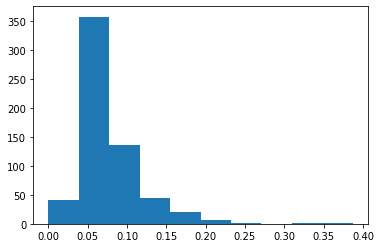

In [25]:
 
plt.hist( inflected_counts, bins=10)

(array([261., 268.,  53.,  18.,   9.,   0.,   0.,   0.,   1.,   2.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333]),
 <a list of 10 Patch objects>)

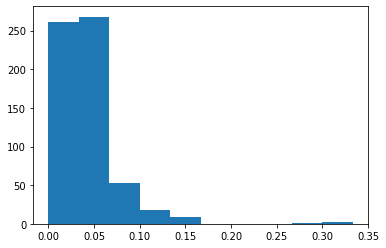

In [26]:
plt.hist(lemma_counts, bins=10)